In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# !pip uninstall umap --yes
# !pip uninstall umap-learn --yes
# !pip3 install umap-learn
# !conda uninstall umap-learn
# !pip freeze
# !conda install -y -c conda-forge umap-learn --force-reinstall

In [3]:
# !pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113 --force-reinstall

In [4]:
# import torchvision

In [5]:
# !pip install decord==0.6.0 h5py==3.5.0 hdfdict==0.3.1 imageio==2.9.0 imageio-ffmpeg==0.4.5 jupyter notebook kymatio==0.2.1 librosa==0.9.1 matplotlib==3.5.1 numba==0.54.1 numpy==1.20.3 opencv-contrib-python==4.5.5.64 opt_einsum==3.3.0 pandas==1.3.5 Pillow==9.0.1 PuLP==2.6.0 PyWavelets==1.2.0  PyYAML==5.4.1 rolling-quantiles==1.0.0 scanimage-tiff-reader==1.4.1 scikit-image==0.19.1 scikit-learn==1.0.2 scipy==1.7.3 seaborn==0.11.2 sparse==0.13.0 tqdm==4.63.0 umap-learn==0.5.3
# !pip3 install torch torchvision==0.12 torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [6]:
# !conda install -y -c conda-forge umap-learn

In [7]:
# !pip install numpy==1.21

In [8]:
### Import personal libraries

import importlib.util
import glob
from pathlib import Path
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy.stats
from kymatio import Scattering2D
import json
import numpy as np
print(np.__version__)
import torchvision
print(torchvision.__version__)
import torch
from tqdm.notebook import tqdm, trange
import sklearn
from sklearn.model_selection import train_test_split, ShuffleSplit
import sys

%load_ext autoreload
%autoreload 2
%matplotlib notebook

1.21.0
0.12.0+cu113


In [16]:
import json
path_params = '/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/scripts/eval/params.json'

params_eval = dict(
    classifier_n_splits = 15,
    logistic_max_iter = 20000,
    pc_sweep = [0, 10, 18, 33, 60],
    input_dir = '/n/data1/hms/neurobio/sabatini/rich/analysis/ROI_net_training/20220511_SimCLR_penaltyOrth',
    model_loc = '/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/scripts/eval/model.py',
#     output_job_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp_eval/job_0',
    C_toUse = [1000, 100, 10,1,0.1,0.01,0.001,0.0001],
    path_stat = r'/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/stat.npy',
    path_labels = [r'/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/labels_round2_sesh1.npy',
                   r'/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/labels_round2_sesh2.npy'],
    github_loc = '/n/data1/hms/neurobio/sabatini/josh/github_repos',
    debug_mode = False,
)
with open(path_params, 'w') as f:
    json.dump(params_eval, f)

In [ ]:
"/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/scripts/eval/eval-params-sweep.py" "/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/scripts/eval/params.json" "/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/scripts/eval/save_dir/job_0"



In [10]:
import os
print(f"script environment: {os.environ['CONDA_DEFAULT_ENV']}")

import sys
# path_script, path_params, dir_save = sys.argv
path_script = '/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/scripts/eval/eval-params-sweep.py'
path_params = '/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/scripts/eval/params.json'
dir_save = '/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/scripts/eval/save_dir/job_0'

import json
with open(path_params, 'r') as f:
    params_eval = json.load(f)

model_loc = params_eval['model_loc']

import shutil
from pathlib import Path
shutil.copy2(path_script, str(Path(dir_save) / Path(path_script).name));

script environment: jupyter_launcher


In [11]:
# sys.path.append(params['paths']['dir_github'])
# sys.path.append('/Users/josh/Documents/github_repos')
sys.path.append(params_eval['github_loc'])
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc, decomposition, path_helpers
from GCaMP_ROI_classifier import util, models, training, augmentation, dataset

In [17]:
# debug_mode = False
# debug_mode = True

debug_mode = params_eval['debug_mode']

In [13]:
if debug_mode:
#     plot_title_params_key = 'temperature'
    classifier_n_splits = 2
    logistic_max_iter = 6000
    pc_sweep = [0, 10]
else:
#     plot_title_params_key = 'temperature'
    classifier_n_splits = params_eval['classifier_n_splits']
    logistic_max_iter = params_eval['logistic_max_iter']
    pc_sweep = params_eval['pc_sweep']

In [14]:
######
# Final Goal: python eval_func.py .../analysis/ROI_net_training/simCLR_paramsweep_temp .../analysis/ROI_net_training/blablahblah_outputs/jobNum_0
######

########################################################################################################################

# base_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/20220510_testingSimCLRscript/jobNum_*/'
# base_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp'
# base_dir = '/Users/josh/Documents/analysis/analysis/ROI_net_training/simCLR_paramsweep_temp'
# base_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp'


########################################################################################################################


# input_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp'
# output_job_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp_eval/job_0'

# input_dir = '/n/data1/hms/neurobio/sabatini/rich/analysis/ROI_net_training/20220511_SimCLR_penaltyOrth'
# output_job_dir = '/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp_eval/job_0'


input_dir = params_eval['input_dir']
output_job_dir = dir_save

########################################################################################################################

jns = sorted(glob.glob(str(Path(input_dir) / 'jobNum_*')))

if debug_mode:
    jns = jns[:2]

In [15]:
with open(sorted(glob.glob(str(Path(input_dir) / '*.json')))[0], 'rb') as f:
    params_batch = json.load(f)
plot_title_job_num_ids = params_batch['params_changing']

In [15]:
plot_title_job_num_ids

[{'penalty_orthogonality': 0.02},
 {'penalty_orthogonality': 0.2},
 {'penalty_orthogonality': 2.0},
 {'penalty_orthogonality': 20.0}]

In [16]:
# image_out_size = list(dataset[0][0][0].shape)

def model_from_params(params, ModelTackOn, image_out_size=[3, 224, 224], pref_log_all_steps=False):
    base_model_frozen = torchvision.models.__dict__[params['torchvision_model']](pretrained=True)
    for param in base_model_frozen.parameters():
        param.requires_grad = False
    if pref_log_all_steps:
        write_to_log(path_log=path_saveLog, text=f'time:{time.ctime()}  imported pretrained model')

    ### Make combined model

    ## Tacking on the latent layers needs to be done in a few steps.

    ## 0. Chop the base model
    ## 1. Tack on a pooling layer to reduce the size of the convlutional parameters
    ## 2. Determine the size of the output (internally done in ModelTackOn)
    ## 3. Tack on a linear layer of the correct size  (internally done in ModelTackOn)

    if pref_log_all_steps:
        write_to_log(path_log=path_saveLog, text=f'time:{time.ctime()}  making combined model...')

    model_chopped = torch.nn.Sequential(list(base_model_frozen.children())[0][:params['n_block_toInclude']])  ## 0.
    model_chopped_pooled = torch.nn.Sequential(model_chopped, torch.nn.AdaptiveAvgPool2d(output_size=1), torch.nn.Flatten())  ## 1.
    
    data_dim = tuple([1] + list(image_out_size))
    
    model = ModelTackOn(
    #     model_chopped.to('cpu'),
        model_chopped_pooled.to('cpu'),
        base_model_frozen.to('cpu'),
        data_dim=data_dim,
        pre_head_fc_sizes=params['pre_head_fc_sizes'], 
        post_head_fc_sizes=params['post_head_fc_sizes'], 
        classifier_fc_sizes=None,
        nonlinearity=params['head_nonlinearity'],
        kwargs_nonlinearity={},
    )
    return base_model_frozen, model_chopped, model_chopped_pooled, image_out_size, data_dim, model

def helper_make_dataset(X, scripted_transforms_classifier):
    out = dataset.dataset_simCLR(
        X=torch.as_tensor(X, device='cpu', dtype=torch.float32),
        y=torch.as_tensor(torch.zeros(X.shape[0]), device='cpu', dtype=torch.float32),
        n_transforms=1,
        class_weights=np.array([1]),
        transform=scripted_transforms_classifier,
        DEVICE='cpu',
        dtype_X=torch.float32,
    )
    return out

def helper_make_dataloader(ds):
    out = torch.utils.data.DataLoader( 
        ds,
#         batch_size=128,
        batch_size=8,
        shuffle=False,
        drop_last=False
    )
    return out

def get_balanced_sample_weights(labels):
    labels = np.int64(labels.copy())
    counts, vals = np.histogram(labels, bins=np.concatenate((np.unique(labels), [labels.max()+1])))
    vals = vals[:-1]

    n_labels = len(labels)
    weights = n_labels / counts
    
    sample_weights = np.array([weights[l] for l in labels])
    
    return sample_weights

def get_latents_swt(sfs, swt, device_model):
    sfs = torch.as_tensor(np.ascontiguousarray(sfs[None,...]), device=device_model, dtype=torch.float32)
    latents_swt = swt(sfs[None,...]).squeeze()
    latents_swt = latents_swt.reshape(latents_swt.shape[0], -1)
    return latents_swt


In [17]:
pth_fn_dct = {}
log_fn_dct = {}
loss_fn_dct = {}
params_fn_dct = {}
run_outputs_fn_dct = {}
sbatch_config_fn_dct = {}
base_py_fn_dct = {}

params_dct = {}
run_outputs_dct = {}

for jn in jns:
    print(jn)
    
    pth_fn = glob.glob(str(Path(jn) / '*.pth'))
    log_fn = glob.glob(str(Path(jn) / 'log.txt'))
    loss_fn = glob.glob(str(Path(jn) / 'loss.npy'))
    params_fn = glob.glob(str(Path(jn) / 'params.json'))
    run_outputs_fn = glob.glob(str(Path(jn) / 'run_outputs.json'))
    sbatch_config_fn = glob.glob(str(Path(jn) / 'sbatch_config.sh'))
    base_py_fn = glob.glob(str(Path(jn) / '*.py'))
    
    assert len(pth_fn) == 1
    assert len(log_fn) == 1
    assert len(loss_fn) == 1
    assert len(params_fn) == 1
    assert len(run_outputs_fn) == 1
    assert len(sbatch_config_fn) == 1
    assert len(base_py_fn) == 1
    
    
    with open(params_fn[0], 'rb') as f:
        params_dct[jn] = json.load(f)
        
    with open(run_outputs_fn[0], 'rb') as f:
        run_outputs_dct[jn] = json.load(f)
    
    pth_fn_dct[jn] = pth_fn[0]
    log_fn_dct[jn] = log_fn[0]
    loss_fn_dct[jn] = loss_fn[0]
    params_fn_dct[jn] = params_fn[0]
    run_outputs_fn_dct[jn] = run_outputs_fn[0]
    sbatch_config_fn_dct[jn] = sbatch_config_fn[0]
    base_py_fn_dct[jn] = base_py_fn[0]
    
    

/n/data1/hms/neurobio/sabatini/rich/analysis/ROI_net_training/20220511_SimCLR_penaltyOrth/jobNum_0
/n/data1/hms/neurobio/sabatini/rich/analysis/ROI_net_training/20220511_SimCLR_penaltyOrth/jobNum_1


In [18]:
# params = params_lst[0]
# run_outputs = run_outputs_lst[0]

In [19]:
torchvision

<module 'torchvision' from '/home/joz608/.conda/envs/jupyter_launcher/lib/python3.8/site-packages/torchvision/__init__.py'>

In [20]:
# import PIL

In [21]:
# images_labeled.shape, [np.load(path).shape for path in path_labels]

<IPython.core.display.Javascript object>


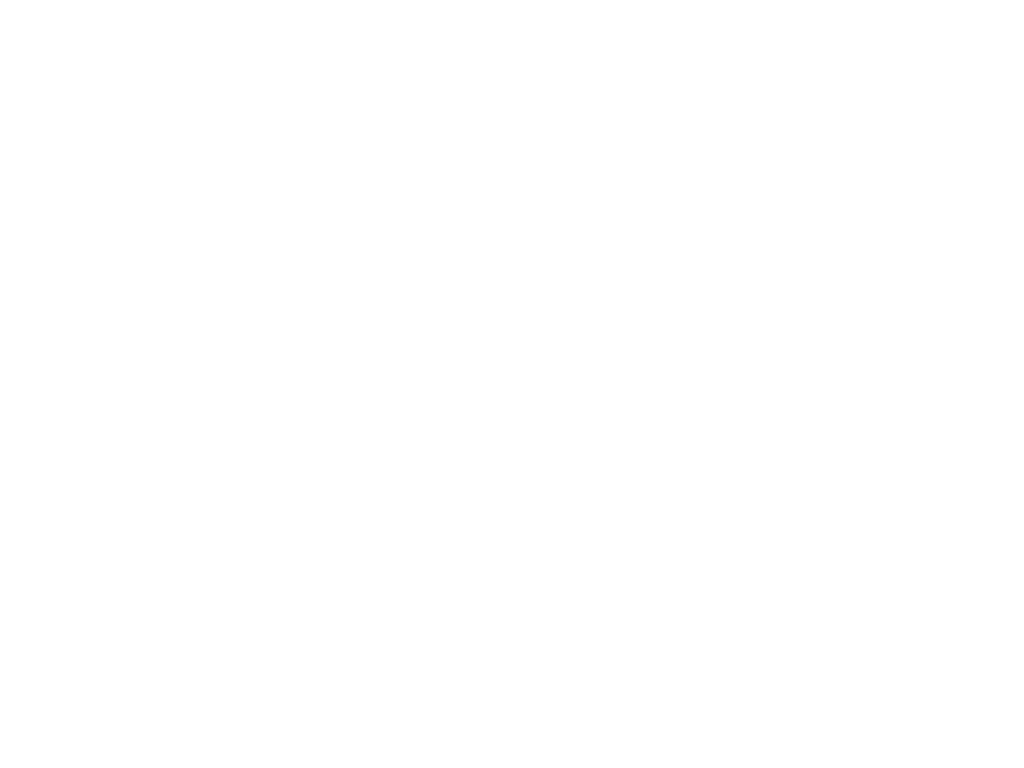

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
path_stat = params_eval['path_stat']#r'/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/stat.npy'
path_labels = params_eval['path_labels']#[r'/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/labels_round2_sesh1.npy',
               #r'/n/data1/hms/neurobio/sabatini/josh/github_repos/GCaMP_ROI_classifier/data/training/mouse2_6__20210409/labels_round2_sesh2.npy']

#np.concatenate(
images_labeled = \
    util.import_multiple_stat_files(   
        paths_statFiles=[path_stat],
        out_height_width=[36,36],
        max_footprint_width=241,
        plot_pref=True
    )
# )


sf_all_cat = np.concatenate(images_labeled, axis=0)
sf_all_cat = np.concatenate((sf_all_cat, sf_all_cat), axis=0)

sf_ptiles = np.array([np.percentile(np.sum(sf>0, axis=(1,2)), 90) for sf in tqdm(images_labeled)])
scales_forRS = (250/sf_ptiles)**0.6
sf_rs = [np.stack([util.resize_affine(img, scale=scales_forRS[ii], clamp_range=True) for img in sf], axis=0) for ii, sf in enumerate(tqdm(images_labeled))]
images_labeled = np.concatenate(sf_rs, axis=0)
images_labeled = np.concatenate((images_labeled, images_labeled), axis=0)


labels = classification.squeeze_integers(np.concatenate([np.load(path) for path in path_labels]))

assert images_labeled.shape[0] == labels.shape[0] , 'num images in stat files does not correspond to num labels'


idx_toKeep = np.where(np.logical_not(labels == 4))[0]

images_labeled_clean = images_labeled[idx_toKeep]
labels_clean = labels[idx_toKeep]




<IPython.core.display.Javascript object>


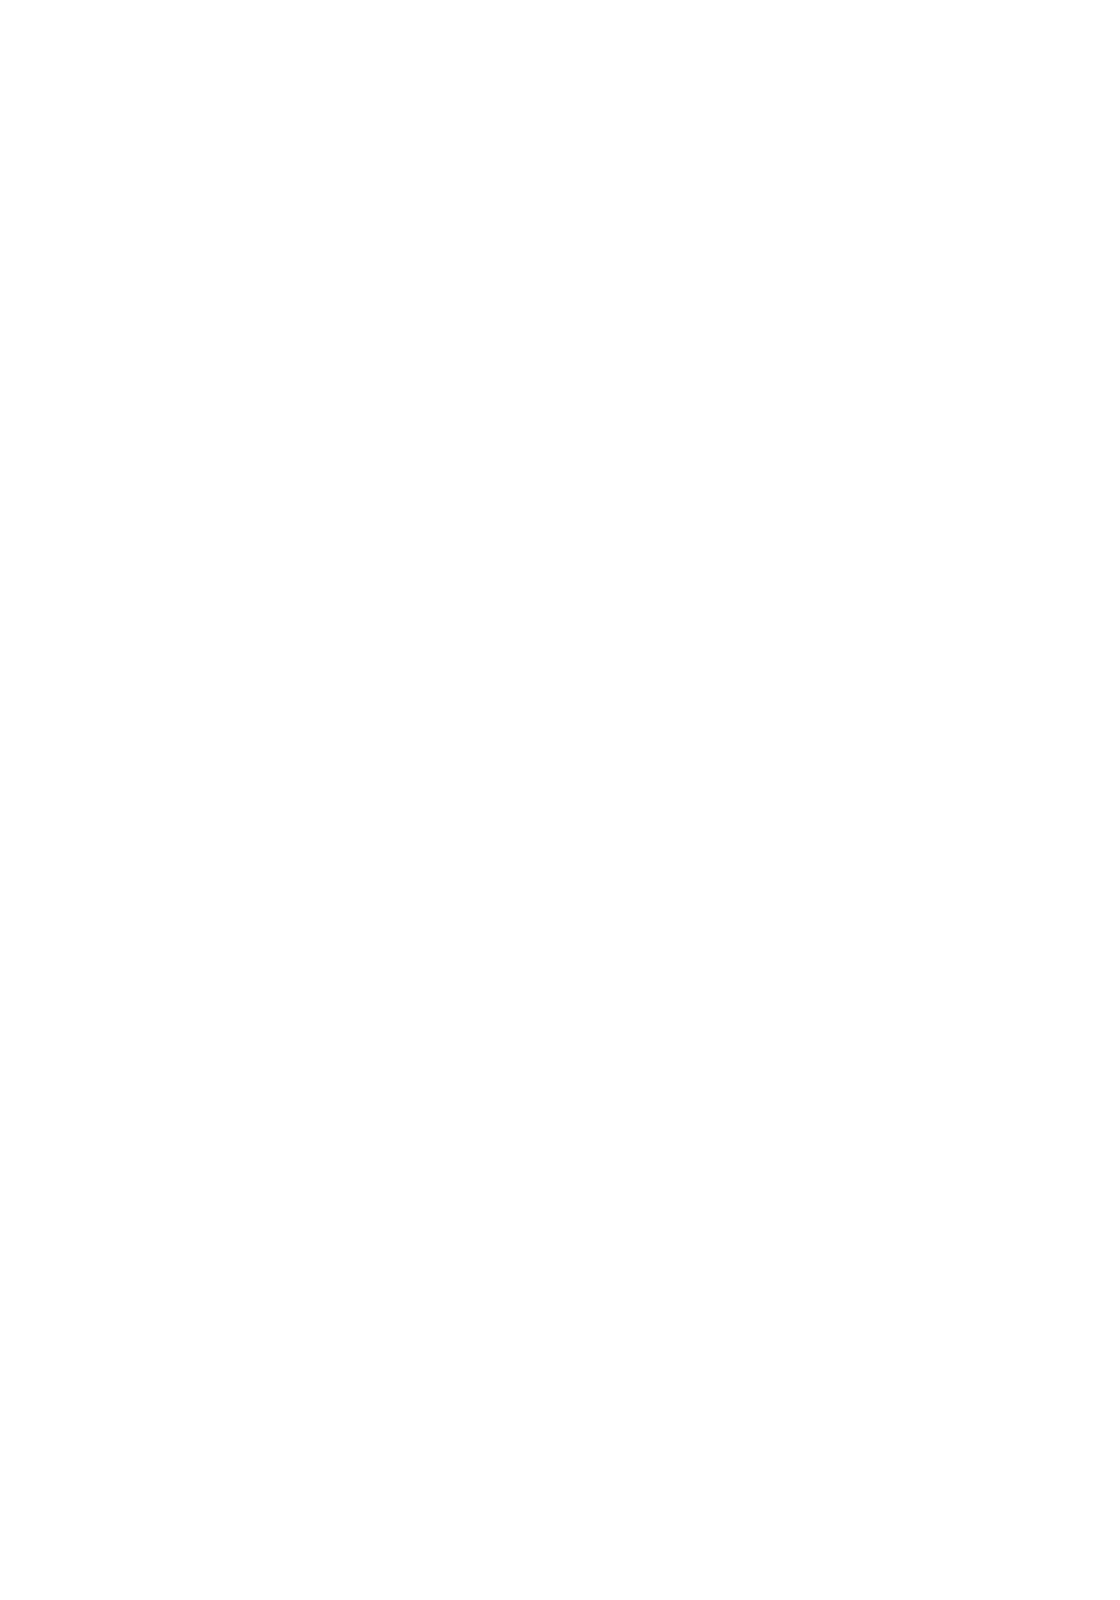

Text(0.5, 1.0, 'ROI sizes resized')

In [23]:
import scipy.signal

figs, axs = plt.subplots(2,1, figsize=(7,10))
axs[0].plot(np.sum(images_labeled > 0, axis=(1,2)))
axs[0].plot(scipy.signal.savgol_filter(np.sum(images_labeled > 0, axis=(1,2)), 501, 3))
axs[0].set_xlabel('ROI number');
axs[0].set_ylabel('mean npix');
axs[0].set_title('ROI sizes raw')

axs[1].plot(np.sum(sf_all_cat > 0, axis=(1,2)))
axs[1].plot(scipy.signal.savgol_filter(np.sum(sf_all_cat > 0, axis=(1,2)), 501, 3))
axs[1].set_xlabel('ROI number');
axs[1].set_ylabel('mean npix');
axs[1].set_title('ROI sizes resized')



In [24]:
!cat {glob.glob(str(Path(input_dir) / '*.py'))[0]}

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

# # !source activate jupyter_launcher
# !pip3 install numba
# !pip3 install matplotlib
# !pip3 install scipy
# !pip3 install torch
# !pip3 install torchvision
# !pip3 install sklearn
# !pip3 install pycuda
# !pip3 install tqdm
# !pip3 install seaborn
# !pip3 install h5py
# !pip3 install hdfdict
# !pip3 install ipywidgets
# !pip3 install numpy==1.20

import sys
print(sys.version_info)

import os
print(os.environ['CONDA_DEFAULT_ENV'])

import copy
import pathlib
from pathlib import Path
import time
import gc

from tqdm import tqdm, trange

import numpy as np
import scipy

import torch
import torchvision
import torchvision.transforms as transforms



## Parse arguments

import sys
path_script, path_params, dir_save = sys.argv
dir_save = Path(dir_save)
                
import json
with open(path_params, 'r') as f:
    params = json.load(f)

import shutil
shutil.copy2(pat

In [25]:
#### Paste ModelTackOn Definition from above Here...



                                                         
spec = importlib.util.spec_from_file_location(model_loc.split('/')[-1].replace('.py', ''), params_eval['model_loc'])
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)



# ### Define ModelTackOn

# class ModelTackOn(torch.nn.Module):
#     def __init__(
#         self, 
#         base_model, 
#         un_modified_model,
#         data_dim=(1,3,36,36), 
#         pre_head_fc_sizes=[100], 
#         post_head_fc_sizes=[100], 
#         classifier_fc_sizes=None, 
#         nonlinearity='relu', 
#         kwargs_nonlinearity={},
#     ):
#             super(ModelTackOn, self).__init__()
#             self.base_model = base_model
#             final_base_layer = list(un_modified_model.children())[-1]
#             # final_base_layer = list(list(model.children())[-1].children())[-1]
#             # print(final_base_layer)
            
#             self.data_dim = data_dim

#             self.pre_head_fc_lst = []
#             self.post_head_fc_lst = []
#             self.classifier_fc_lst = []
                
#             self.nonlinearity = nonlinearity
#             self.kwargs_nonlinearity = kwargs_nonlinearity

#             self.init_prehead(final_base_layer, pre_head_fc_sizes)
#             self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
#             if classifier_fc_sizes is not None:
#                 self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
            
#     def init_prehead(self, prv_layer, pre_head_fc_sizes):
#         for i, pre_head_fc in enumerate(pre_head_fc_sizes):
#             if i == 0:
# #                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1280
# #                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 960
# #                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 768
# #                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1536
# #                 in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1024
#                 in_features = self.base_model(torch.rand(*(self.data_dim))).data.squeeze().shape[0]  ## RH EDIT
#             else:
#                 in_features = pre_head_fc_sizes[i - 1]
#             fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
#             self.add_module(f'PreHead_{i}', fc_layer)
#             self.pre_head_fc_lst.append(fc_layer)

# #             if i < len(pre_head_fc_sizes) - 1:
# #             non_linearity = torch.nn.ReLU()
# #             non_linearity = torch.nn.GELU()
#             non_linearity = torch.nn.__dict__[self.nonlinearity](**self.kwargs_nonlinearity)
#             self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
#             self.pre_head_fc_lst.append(non_linearity)

#     def init_posthead(self, prv_size, post_head_fc_sizes):
#         for i, post_head_fc in enumerate(post_head_fc_sizes):
#             if i == 0:
#                 in_features = prv_size
#             else:
#                 in_features = post_head_fc_sizes[i - 1]
#             fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
#             self.add_module(f'PostHead_{i}', fc_layer)
#             self.post_head_fc_lst.append(fc_layer)

# #                 non_linearity = torch.nn.ReLU()
# #                 non_linearity = torch.nn.GELU()
#             non_linearity = torch.nn.__dict__[self.nonlinearity](**self.kwargs_nonlinearity)    
#             self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
#             self.pre_head_fc_lst.append(non_linearity)
    
#     def init_classifier(self, prv_size, classifier_fc_sizes):
#             for i, classifier_fc in enumerate(classifier_fc_sizes):
#                 if i == 0:
#                     in_features = prv_size
#                 else:
#                     in_features = classifier_fc_sizes[i - 1]
#             fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
#             self.add_module(f'Classifier_{i}', fc_layer)
#             self.classifier_fc_lst.append(fc_layer)

#     def reinit_classifier(self):
#         for i_layer, layer in enumerate(self.classifier_fc_lst):
#             layer.reset_parameters()
    
# #     def forward(self, X):
# #         interim = self.base_model(X)
# #         interim = self.get_head(interim)
# #         interim = self.get_latent(interim)
# #         return interim

#     def forward_classifier(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.classify(interim)
#         return interim

#     def forward_latent(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim


#     def get_head(self, base_out):
#         # print('base_out', base_out.shape)
#         head = base_out
#         for pre_head_layer in self.pre_head_fc_lst:
#           # print('pre_head_layer', pre_head_layer.in_features)
#           head = pre_head_layer(head)
#           # print('head', head.shape)
#         return head

#     def get_latent(self, head):
#         latent = head
#         for post_head_layer in self.post_head_fc_lst:
#             latent = post_head_layer(latent)
#         return latent

#     def classify(self, head):
#         logit = head
#         for classifier_layer in self.classifier_fc_lst:
#             logit = classifier_layer(logit)
#         return logit

#     def set_pre_head_grad(self, requires_grad=True):
#         for layer in self.pre_head_fc_lst:
#             for param in layer.parameters():
#                 param.requires_grad = requires_grad
                
#     def set_post_head_grad(self, requires_grad=True):
#         for layer in self.post_head_fc_lst:
#             for param in layer.parameters():
#                 param.requires_grad = requires_grad

#     def set_classifier_grad(self, requires_grad=True):
#         for layer in self.classifier_fc_lst:
#             for param in layer.parameters():
#                 param.requires_grad = requires_grad

#     def prep_contrast(self):
#         self.set_pre_head_grad(requires_grad=True)
#         self.set_post_head_grad(requires_grad=True)
#         self.set_classifier_grad(requires_grad=False)

#     def prep_classifier(self):
#         self.set_pre_head_grad(requires_grad=False)
#         self.set_post_head_grad(requires_grad=False)
#         self.set_classifier_grad(requires_grad=True)


In [26]:
mod_dct_dct = {}

scree_plt_dct = {}
corr_plt_dct = {}
acc_plt_dct = {}
cm_plt_dct = {}
embeddings_plt_dct = {}
title_val_plt_dct = {}
features_nn_plt_dct = {}
img_grid_plt_dct = {}
scores_nn_plt_dct = {}
labels_clean_plt_dct = {}
run_id_dct = {}
pc_id_dct = {}

i = -1

for jn in (pbar_params_set := tqdm(params_dct)):
    i += 1
    
    pbar_params_set.set_description(f'Params # — {i}')
    
    scree_plt_dct[jn] = {}
    corr_plt_dct[jn] = {}
    acc_plt_dct[jn] = {}
    cm_plt_dct[jn] = {}
    embeddings_plt_dct[jn] = {}
    title_val_plt_dct[jn] = {}
    features_nn_plt_dct[jn] = {}
    img_grid_plt_dct[jn] = {}
    scores_nn_plt_dct[jn] = {}
    labels_clean_plt_dct[jn] = {}
    
    run_id_dct[jn] = str(plot_title_job_num_ids[i]) #str(params_dct[jn][plot_title_params_key])
    print(run_id_dct)
    
    params = params_dct[jn]
    run_outputs = run_outputs_dct[jn]
    base_py_fn = base_py_fn_dct[jn]
    
    device_dataloader = torch_helpers.set_device(use_GPU=params['useGPU_dataloader'])
    DEVICE = torch_helpers.set_device(use_GPU=params['useGPU_training'])
    
    
#     spec = importlib.util.spec_from_file_location(base_py_fn.split('/')[-1][:-3], base_py_fn)
#     module = importlib.util.module_from_spec(spec)
#     spec.loader.exec_module(module)
    
    (base_model_frozen, model_chopped, model_chopped_pooled,
    image_out_size, data_dim, model) = model_from_params(params,
                                                         module.ModelTackOn,
#                                                          ModelTackOn,
                                                         image_out_size=run_outputs['image_resized_shape'],
                                                         pref_log_all_steps=False)
    
    
    
    
    mod_dct_dct[jn] = {name: param.detach().numpy() for name, param in model.named_parameters()}

    
    
    
    ### unfreeze particular blocks in model

    mnp = [name for name, param in model.named_parameters()]  ## 'model named parameters'
    mnp_blockNums = [name[name.find('.'):name.find('.')+8] for name in mnp]  ## pulls out the numbers just after the model name
    mnp_nums = [path_helpers.get_nums_from_string(name) for name in mnp_blockNums]  ## converts them to numbers
#     block_to_freeze_nums = path_helpers.get_nums_from_string(params['block_to_unfreeze'])  ## converts the input parameter specifying the block to freeze into a number for comparison

    m_baseName = mnp[0][:mnp[0].find('.')]

#     for ii, (name, param) in enumerate(model.named_parameters()):
#         if m_baseName in name:
#     #         print(name)
#             if mnp_nums[ii] < block_to_freeze_nums:
#                 param.requires_grad = False
#             elif mnp_nums[ii] >= block_to_freeze_nums:
#                 param.requires_grad = True

#     names_layers_requiresGrad = [( param.requires_grad , name ) for name,param in list(model.named_parameters())]



    # ### Training

    # model.to(device_train)
    # model.prep_contrast()
    model.forward = model.forward_latent
    
    # ### Define augmentation pipeline

    # aug_params = {
    #     'Scale_image_sum': params['augmentation']['Scale_image_sum'],
    #     'ScaleDynamicRange': params['augmentation']['ScaleDynamicRange'],
    #     'TileChannels': params['augmentation']['TileChannels'],
    # }
    # transforms_classifier = torch.nn.Sequential(
    # #     *[augmentation.__dict__[key](**params) for key,params in params['augmentation'].items()]
    #     *[augmentation.__dict__[key](**params) for key,params in aug_params.items()]
    # )

    transforms_classifier = torch.nn.Sequential(
        augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
        torchvision.transforms.Resize(
            size=(224, 224),   
            interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
        augmentation.TileChannels(dim=0, n_channels=3),
    )

    scripted_transforms_classifier = torch.jit.script(transforms_classifier)
    
    
    
    dataset_labeled_clean = helper_make_dataset(images_labeled_clean, scripted_transforms_classifier)
    dataloader_labeled_clean = helper_make_dataloader(dataset_labeled_clean)

    model.eval()
    model.to(DEVICE)
    features_nn = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for idata, data in enumerate(tqdm(dataloader_labeled_clean))], dim=0)
    
    if i != 0:
        print('All Close:', np.allclose(features_nn.numpy(), prv_features_nn))
    prv_features_nn = features_nn.numpy().copy()
    

    features_nn_z = scipy.stats.zscore(features_nn.numpy(), axis=0)
    features_nn_z = features_nn_z[:, ~np.isnan(features_nn_z[0,:])]
    features_nn_z = torch.as_tensor(features_nn_z, dtype=torch.float32)
    
    ipcs = -1
    
    for rank in (pbar_pc_sweep := tqdm(pc_sweep)):
        ipcs += 1
        pbar_pc_sweep.set_description(f'PCA Rank {rank}')
        
        if rank == 0:
            comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn, zscore=False)
        else:
            comp_nn, scores_nn, SVs, EVR_nn = decomposition.torch_pca(features_nn, rank=rank, zscore=False)
        
        features_norm = torch.cat([val / torch.std(val, dim=0).mean() for val in [scores_nn]], dim=1)
        features_train, features_val, labels_train, labels_val = sklearn.model_selection.train_test_split(features_norm, labels_clean, test_size=0.3)
#         print(f'train / test shapes: images_labeled_train, images_labeled_val, labels_train, labels_val: {features_train.shape, features_val.shape, labels_train.shape, labels_val.shape}')

        acc_train, acc_val = [], []
        cm_tr, cm_val, train_cms, test_cms = [], [], [], []
        C_toUse = params_eval['C_toUse']
#         for C in C_toUse:
#             logreg = sklearn.linear_model.LogisticRegression(
#                 solver='lbfgs',
#                 max_iter=logistic_max_iter,
#                 C=C,
#                 fit_intercept=True, 
#                 class_weight='balanced',
#             )
#             logreg.fit(features_train, labels_train)
            
#             acc = logreg.score(features_train, labels_train, sample_weight=get_balanced_sample_weights(labels_train))
#             acc_train.append(acc)
            
#             acc = logreg.score(features_val, labels_val, sample_weight=get_balanced_sample_weights(labels_val))
#             acc_val.append(acc)
            

        splitter = ShuffleSplit(n_splits=classifier_n_splits)
        all_split_inx = list(splitter.split(features_train))

        train_X = [features_norm[_[0]] for _ in all_split_inx]
        test_X = [features_norm[_[1]] for _ in all_split_inx]
        train_y = [labels_clean[_[0]] for _ in all_split_inx]
        test_y = [labels_clean[_[1]] for _ in all_split_inx]
        
        for ic, c in enumerate(C_toUse):
#         for ic, c in enumerate(pbar_C := tqdm(C_toUse)):
            pbar_pc_sweep.set_description(f'PCA Rank {rank}: {ipcs}/{len(pc_sweep) - 1} — Regularization C {c}')
            
            train_cms_cv = []
            test_cms_cv = []
            
            acc_tr_cv = []
            acc_val_cv = []
            
            for inx_split in range(len(train_X)):
                pbar_pc_sweep.set_description(f'PCA Rank {rank}: {ipcs}/{len(pc_sweep) - 1} — Regularization C {c}: {inx_split}/{len(train_X) - 1}')
                
#                 if inx_split != 0:
#                     prv_tmp_train_X = tmp_train_X
                
                tmp_train_X = train_X[inx_split]
                tmp_train_y = train_y[inx_split]

                tmp_test_X = test_X[inx_split]
                tmp_test_y = test_y[inx_split]
                
#                 if inx_split != 0:
#                     print('npac', np.allclose(prv_tmp_train_X, tmp_train_X))
#                     print(prv_tmp_train_X)
#                     print(tmp_train_X)
# #                     print('npac', np.allclose(prv_tmp_train_X, tmp_train_X))
                
#                 print(inx_split)


                logreg = sklearn.linear_model.LogisticRegression(
                    solver='lbfgs',
                    max_iter=logistic_max_iter, 
#                     C=10**(0),
                    C=c,
                    fit_intercept=True, 
                    class_weight='balanced',
                )
                logreg.fit(tmp_train_X, tmp_train_y)
                
#                 print('lrg.coef_', logreg.coef_)
#                 print('lrg.intercept_', logreg.intercept_)

#                 svm = sklearn.svm.SVC(
#                     C=10**(1), 
#                     kernel='rbf',
#                     degree=3, 
#                     gamma='scale',
#                     coef0=0.0, 
#                     shrinking=True,
#                     probability=False, 
#                     tol=0.001, 
#                     cache_size=200,
#                     class_weight='balanced',
#                     verbose=False, 
#                     max_iter=- 1, 
#                     decision_function_shape='ovr',
#                     break_ties=False,
#                     random_state=None
#                 )
#                 svm.fit(tmp_train_X, tmp_train_y)
                
                

                proba = logreg.predict_proba(tmp_train_X)
                preds = np.argmax(proba, axis=1)
                cm_tr_individual = classification.confusion_matrix(preds, tmp_train_y.astype(np.int32))
                
                acc_tr_cv_individual = logreg.score(tmp_train_X, tmp_train_y.astype(np.int32), sample_weight=get_balanced_sample_weights(tmp_train_y.astype(np.int32)))
                
#                 print('acc_tr_cv_individual', acc_tr_cv_individual)
                acc_tr_cv.append(acc_tr_cv_individual)
                train_cms_cv.append(cm_tr_individual)
                
                
                
                
                proba2 = logreg.predict_proba(tmp_test_X)
                preds2 = np.argmax(proba2, axis=1)
                cm_val2_individual = classification.confusion_matrix(preds2, tmp_test_y.astype(np.int32))
                
                acc_val_cv_individual2 = logreg.score(tmp_test_X, tmp_test_y.astype(np.int32), sample_weight=get_balanced_sample_weights(tmp_test_y.astype(np.int32)))
                
#                 print('acc_val_cv_individual2', acc_val_cv_individual2)
                acc_val_cv.append(acc_val_cv_individual2)
                test_cms_cv.append(cm_val2_individual)
                
                
# #                 print('tr_preds',np.mean(preds == tmp_train_y.astype(np.int32)))
# #                 print('val_preds',np.mean(preds2 == tmp_test_y.astype(np.int32)))
#                 print('tr_preds',acc_tr_cv_individual)
#                 print('val_preds',acc_val_cv_individual2)
                
                
            acc_train.append(np.array(acc_tr_cv).reshape(1,-1))
            acc_val.append(np.array(acc_val_cv).reshape(1,-1))
            
            train_cms.append(np.expand_dims(np.mean(np.array(train_cms_cv), axis=0), axis=0))
            test_cms.append(np.expand_dims(np.mean(np.array(test_cms_cv), axis=0), axis=0))
            
#             acc_train.append(np.mean(acc_tr_cv, axis=0))
#             acc_val.append(np.mean(acc_val_cv, axis=0))
            
#             print('acc_train', acc_train)
# #             print('acc_tr_cv', acc_tr_cv)
#             print('acc_val', acc_val)
# #             print('acc_val_cv', acc_val_cv)
                
#         print(acc_train, acc_val)
        
        acc_train = np.concatenate(acc_train, axis=0)
        acc_val = np.concatenate(acc_val, axis=0)
        
        
#         cm_tr = np.mean(train_cms,axis=0)
#         cm_val = np.mean(test_cms,axis=0)


        cm_tr = np.concatenate(train_cms,axis=0)
        cm_val = np.concatenate(test_cms,axis=0)





        labels_sesh1 = np.load(path_labels[0])
        labels_sesh2 = np.load(path_labels[1])

        labels_sesh12cat = np.concatenate((labels_sesh1, labels_sesh2), axis=0)
        labels_sesh21cat = np.concatenate((labels_sesh2, labels_sesh1), axis=0)


        layer_1 = model.state_dict()['base_model.0.0.0.0.weight'].cpu()

        # layer_1 = model.state_dict()['base_model.0.0.0.weight'].cpu()
        # layer_2 = model.state_dict()['base_model.0.6.3.block.1.0.weight'].cpu()
        # layer_3 = model.state_dict()['base_model.0.7.0.block.1.0.weight'].cpu()
        # layer_4 = model.state_dict()['base_model.0.7.0.block.1.0.weight'].cpu()


        umap = UMAP(
            n_neighbors=30,
            n_components=2,
            metric='euclidean',
            metric_kwds=None,
            output_metric='euclidean',
            output_metric_kwds=None,
            n_epochs=None,
            learning_rate=1.0,
            init='spectral',
            min_dist=0.1,
            spread=1.0,
            low_memory=True,
            n_jobs=-1,
            set_op_mix_ratio=1.0,
            local_connectivity=1.0,
            repulsion_strength=1.0,
            negative_sample_rate=5,
            transform_queue_size=4.0,
            a=None,
            b=None,
            random_state=None,
            angular_rp_forest=False,
            target_n_neighbors=-1,
            target_metric='categorical',
            target_metric_kwds=None,
            target_weight=0.5,
            transform_seed=42,
            transform_mode='embedding',
            force_approximation_algorithm=False,
            verbose=False,
            tqdm_kwds=None,
            unique=False,
            densmap=False,
            dens_lambda=2.0,
            dens_frac=0.3,
            dens_var_shift=0.1,
            output_dens=False,
            disconnection_distance=None,
            precomputed_knn=(None, None, None),
        )

        embeddings = umap.fit_transform(features_nn)


        scree_plt_dct[jn][rank] = EVR_nn.detach().numpy()
        corr_plt_dct[jn][rank] = torch.corrcoef(features_nn.T)
        acc_plt_dct[jn][rank] = {'C':C_toUse, 'acc_tr':acc_train, 'acc_val':acc_val}
        cm_plt_dct[jn][rank] = { 'cm_tr':cm_tr,
                           'cm_val':cm_val,
                           'cm_relabel':classification.confusion_matrix(labels_sesh12cat.astype(np.int32), labels_sesh21cat.astype(np.int32))}
        embeddings_plt_dct[jn][rank] = embeddings
        

        features_nn_plt_dct[jn][rank] = {'features_nn': features_nn,
                                   'features_nn_z': features_nn_z,}
        img_grid_plt_dct[jn][rank] = torch.cat([arr for arr in layer_1], dim=0)
        scores_nn_plt_dct[jn][rank] = scores_nn
        labels_clean_plt_dct[jn][rank] = labels_clean

#         print(f'best val score: {max(acc_val)}')
#         print(f'best C value: {C_toUse[np.argmax(acc_val)]}')
        
        

        

  0%|          | 0/2 [00:00<?, ?it/s]

{'/n/data1/hms/neurobio/sabatini/rich/analysis/ROI_net_training/20220511_SimCLR_penaltyOrth/jobNum_0': "{'penalty_orthogonality': 0.02}"}
device: 'cpu'
device: 'cuda:0'


  0%|          | 0/1205 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'/n/data1/hms/neurobio/sabatini/rich/analysis/ROI_net_training/20220511_SimCLR_penaltyOrth/jobNum_0': "{'penalty_orthogonality': 0.02}", '/n/data1/hms/neurobio/sabatini/rich/analysis/ROI_net_training/20220511_SimCLR_penaltyOrth/jobNum_1': "{'penalty_orthogonality': 0.2}"}
device: 'cpu'
device: 'cuda:0'


  0%|          | 0/1205 [00:00<?, ?it/s]

All Close: False


  0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
# cm_plt_dct['/n/data1/hms/neurobio/sabatini/rich/analysis/ROI_net_training/20220511_SimCLR_penaltyOrth/jobNum_0'][0]['cm_tr'].shape

In [28]:
# acc_plt_dct

In [29]:
# scree_plt_dct[jn] = EVR_nn
# corr_plt_dct[jn] = torch.corrcoef(features_nn.T)
# acc_plt_dct[jn] = {'C':C_toUse, 'acc_tr':acc_train, 'acc_val':acc_val}
# cm_plt_dct[jn] = { 'cm_tr':cm_tr,
#                    'cm_val':cm_val,
#                    'cm_relabel':classification.confusion_matrix(labels_sesh12cat.astype(np.int32), labels_sesh21cat.astype(np.int32))}
# embeddings_plt_dct[jn] = embeddings
# title_val_plt_dct[jn] = str(params[plot_title_params_key]) + f', # PCs: {rank}'


# features_nn_plt_dct[jn] = {'features_nn':features_nn,
#                            'zs_features_nn':scipy.stats.zscore(features_nn.numpy(), axis=0),}
# img_grid_plt_dct[jn] = torch.cat([arr for arr in layer_1], dim=0)
# scores_nn_plt_dct[jn] = scores_nn
# labels_clean_plt_dct[jn] = labels_clean


In [30]:
%matplotlib inline

In [31]:
# setup_pretty_params

In [32]:
def recursive_list_check_params(dct):
    setup_pp = {}
    for key_a in dct:
        if len(str(key_a) + ": " + str(dct[key_a])) <= 70:
            setup_pp[key_a] = str(dct[key_a])
#         elif type(dct[key_a]) is list:
#             setup_pp[key_a] = str(dct[key_a])
        elif type(dct[key_a]) is dict:
            setup_pp[key_a] = recursive_list_check_params(dct[key_a])
        else:
            setup_pp[key_a] = dct[key_a]
    return setup_pp

setup_pretty_params = recursive_list_check_params(params)
# print(setup_pretty_params)
pretty_params = json.dumps(setup_pretty_params, indent=2)
# print(pretty_params)
# # print(params)

  0%|          | 0/2 [00:00<?, ?it/s]

0
10


  0%|          | 0/2 [00:00<?, ?it/s]

0
10


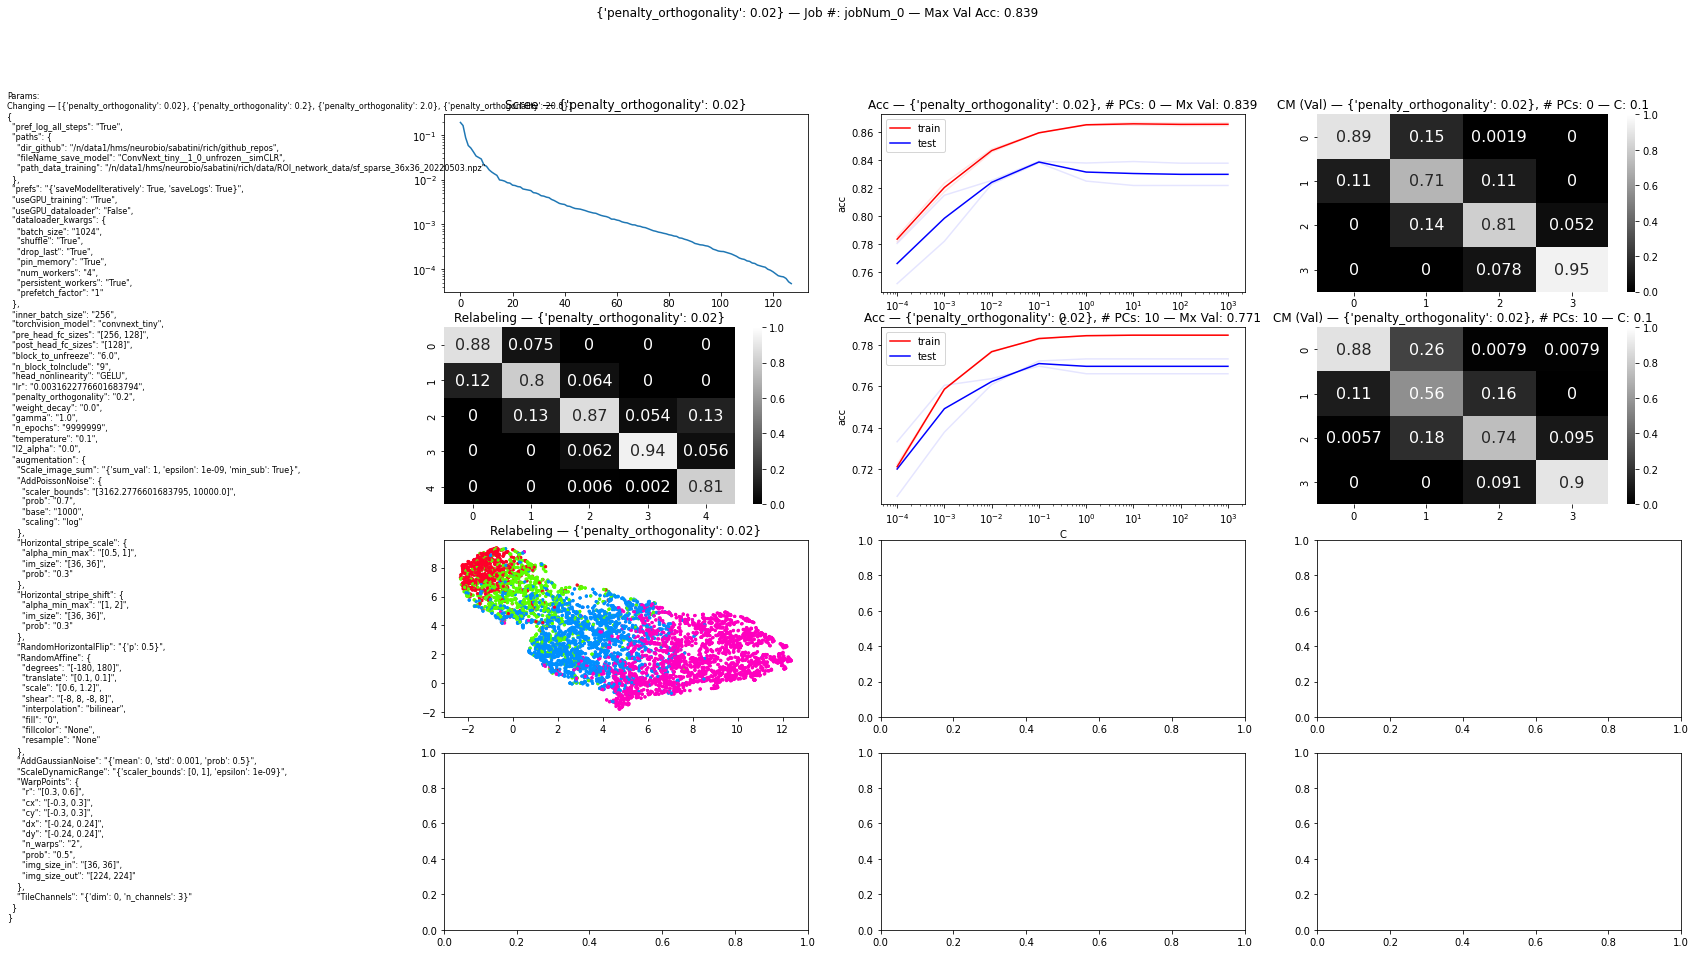

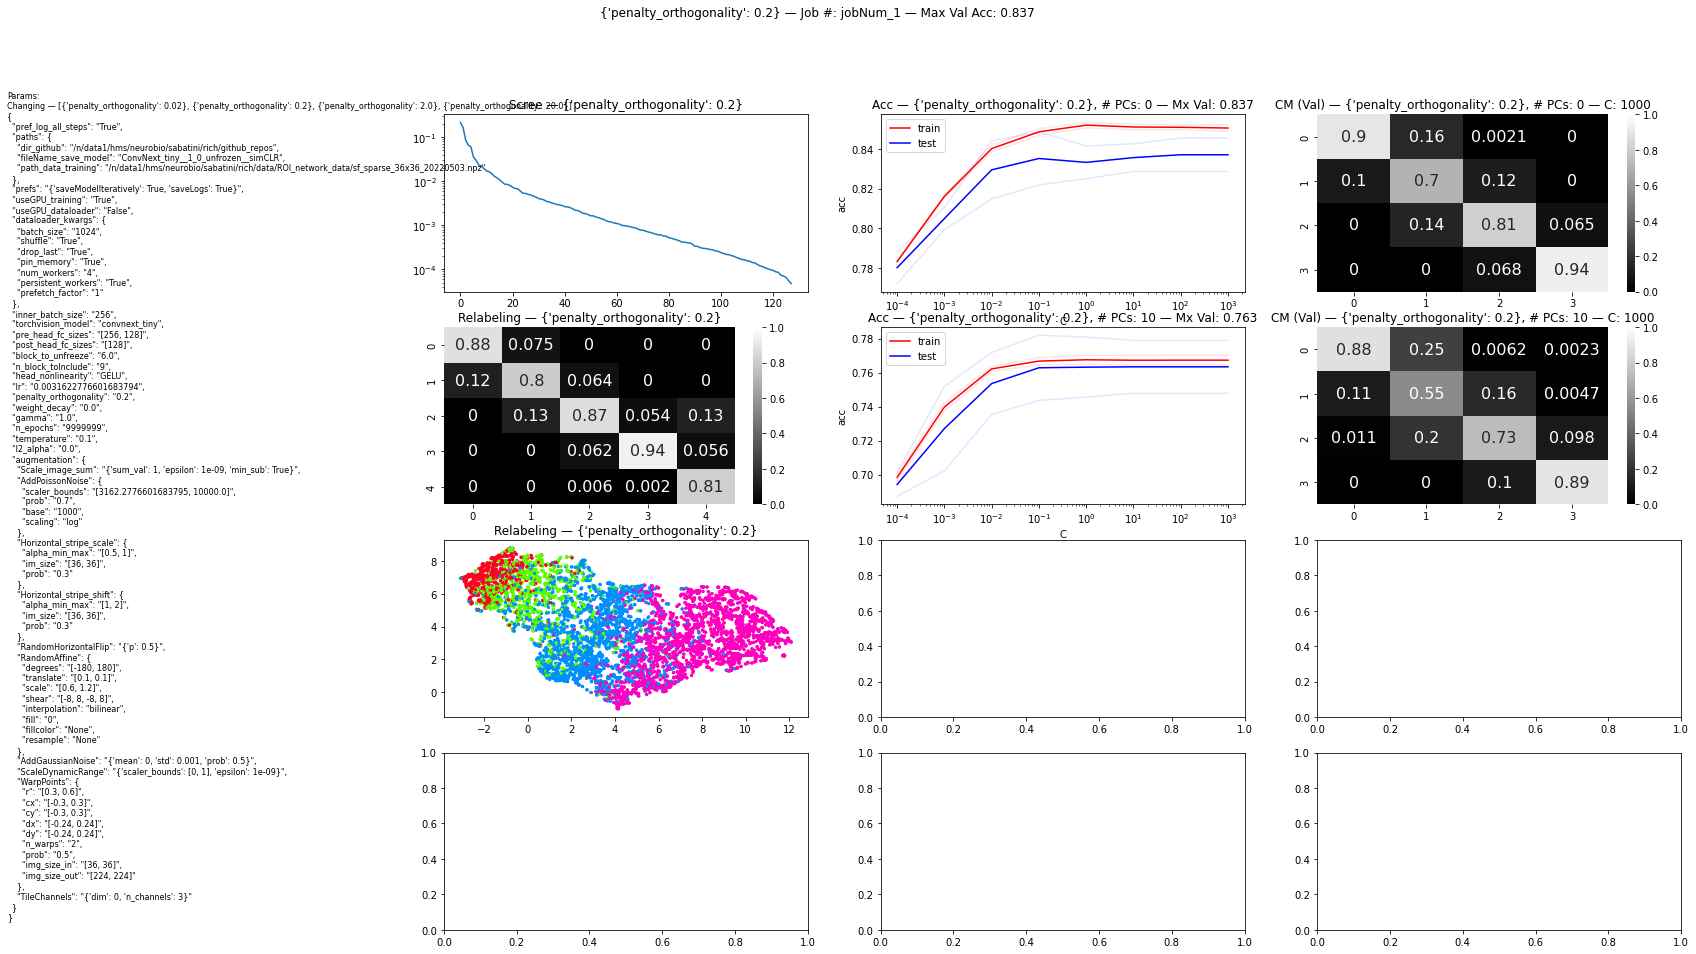

In [37]:
num_rows = max(len(pc_sweep), 4)
# plt.rcParams['axes.facecolor']='white'
# plt.rcParams['savefig.facecolor']='white'

# jn = list(scree_plt_dct.keys())[1]
for jn in scree_plt_dct.keys():
    params = params_dct[jn]
    
    fig, ax = plt.subplots(num_rows, 4, figsize=(30,15))
    fig.set_facecolor('white')
    
    meta_data = \
f"""
Params:
Changing — {plot_title_job_num_ids}
{pretty_params}
"""
    
    for tmp_ax_row in range(num_rows):
        ax[tmp_ax_row,0].axis('off')
#     ax[0,0].invert_yaxis()
    ax[num_rows-1,0].annotate(meta_data, xy=(0, 0), size=8)
    
    overall_plot_col = 1
    
    scree_plt = scree_plt_dct[jn][0]
    ax[0,overall_plot_col].set_yscale('log')
    ax[0,overall_plot_col].set_title(f'Scree — {run_id_dct[jn]}')
    ax[0,overall_plot_col].plot(scree_plt)

    ax[1,overall_plot_col].set_title(f'Relabeling — {run_id_dct[jn]}')
    sns.heatmap(
        np.round(cm_plt_dct[jn][0]['cm_relabel'], 3),
        annot=True, 
        annot_kws={"size": 16}, 
        vmax=1., 
        cmap=plt.get_cmap('gray'),
        ax=ax[1,overall_plot_col]
    )

    
    ax[2,overall_plot_col].scatter(embeddings_plt_dct[jn][0][:,0], embeddings_plt_dct[jn][0][:,1],
                s=5, c=labels_clean_plt_dct[jn][0], cmap='gist_rainbow')
    ax[2,overall_plot_col].set_title(f'Relabeling — {run_id_dct[jn]}')

#     ax[2,1].scatter(embeddings_plt_dct[jn][10][:,0], embeddings_plt_dct[jn][10][:,1],
#                 s=5, c=labels_clean_plt_dct[jn][10], cmap='gist_rainbow')
#     ax[2,1].set_title(f'Relabeling — {title_val_plt_dct[jn][10]}')
    
    best_mean_acc_val_ovrl = -1.0

    for rank_num in trange(len(pc_sweep)):
        
        best_mean_acc_tr = -1.0
        best_i_C_tr = -1.0
        best_mean_acc_val = -1.0
        best_i_C_val = -1.0

        
        rank = pc_sweep[rank_num]
        print(rank)
        
        title_val = f'{run_id_dct[jn]}, # PCs: {rank}'
        
        acc_ax = ax[rank_num,2]
        cm_ax = ax[rank_num,3]
        
        mean_acc_tr = np.mean(acc_plt_dct[jn][rank]['acc_tr'], axis=1)
        mean_acc_val = np.mean(acc_plt_dct[jn][rank]['acc_val'], axis=1)
        
        for i_C in range(mean_acc_val.shape[0]):
            
            if mean_acc_tr[i_C] > best_mean_acc_tr:
                best_mean_acc_tr = mean_acc_tr[i_C]
                best_i_C_tr = i_C
            if mean_acc_val[i_C] > best_mean_acc_val:
                best_mean_acc_val = mean_acc_val[i_C]
                best_i_C_val = i_C
            
            if best_mean_acc_val > best_mean_acc_val_ovrl:
                best_mean_acc_val_ovrl = np.round(best_mean_acc_val, 3)

        acc_ax.plot(acc_plt_dct[jn][rank]['C'], mean_acc_tr, color='r')
        acc_ax.plot(acc_plt_dct[jn][rank]['C'], mean_acc_val, color='b')
        
        bmacv_plt = np.round(best_mean_acc_val,3)
        
        acc_ax.set_title(f'Acc — {title_val} — Mx Val: {bmacv_plt}')
        acc_ax.set_xscale('log')
        acc_ax.set_xlabel('C')
        acc_ax.set_ylabel('acc')
        acc_ax.legend(['train', 'test']);
        
        for sub_cv in range(acc_plt_dct[jn][rank]['acc_tr'].shape[1]):
            acc_ax.plot(acc_plt_dct[jn][rank]['C'], acc_plt_dct[jn][rank]['acc_tr'][:,sub_cv], color='r', alpha=0.1)
        for sub_cv in range(acc_plt_dct[jn][rank]['acc_val'].shape[1]):
            acc_ax.plot(acc_plt_dct[jn][rank]['C'], acc_plt_dct[jn][rank]['acc_val'][:,sub_cv], color='b', alpha=0.1)
        
        cm_C = acc_plt_dct[jn][rank]['C'][best_i_C_val]
        cm_ax.set_title(f'CM (Val) — {title_val} — C: {cm_C}')
        sns.heatmap(cm_plt_dct[jn][rank]['cm_val'][best_i_C_val], annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'), ax=cm_ax)

    fig.suptitle(f"{run_id_dct[jn]} — Job #: {jn.split('/')[-1]} — Max Val Acc: {best_mean_acc_val_ovrl}")
    
    
    report_out_name_jn = jn.split('/')[-1]
    fig.savefig(str(Path(dir_save) / f'report_out_jobnum={report_out_name_jn}.png'))
    
# for plt_inx in range(len(cm_tr_plt_lst)):
#     plt.figure()
#     sns.heatmap(cm_tr_plt_lst[plt_inx], annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
#     plt.title(f'train — {title_val_plt_lst[plt_inx]}');

In [ ]:
# acc_plt_dct[jn][rank]['acc_tr'] = acc_plt_dct[jn][rank]['acc_tr'].T
# acc_plt_dct[jn][rank]['acc_val'] = acc_plt_dct[jn][rank]['acc_val'].T
# acc_plt_dct[jn][rank]['acc_tr'].shape, acc_plt_dct[jn][rank]['acc_val'].shape

In [ ]:
# params

In [ ]:
# acc_plt_dct

In [ ]:
# acc_plt_dct['/n/data1/hms/neurobio/sabatini/josh/analysis/ROI_net_training/simCLR_paramsweep_temp/jobNum_0']

In [ ]:
# for jn in tqdm(scree_plt_dct):
#     plt.figure()
#     plt.plot(scree_plt_dct[jn])
#     plt.yscale('log')
#     plt.title(title_val_plt_lst[jn])

In [ ]:
for plt_inx in range(len(corr_plt_lst)):
    plt.figure()
    plt.imshow(corr_plt_lst[plt_inx])
    plt.title(title_val_plt_lst[plt_inx])

In [ ]:
for plt_inx in range(len(C_toUse_plt_lst)):
    plt.figure()
    plt.plot(C_toUse_plt_lst[plt_inx], acc_tr_plt_lst[plt_inx])
    plt.plot(C_toUse_plt_lst[plt_inx], acc_val_plt_lst[plt_inx])
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('acc')
    plt.legend(['train', 'test']);
    plt.title(title_val_plt_lst[plt_inx])

In [ ]:
for plt_inx in range(len(cm_tr_plt_lst)):
    plt.figure()
    sns.heatmap(cm_tr_plt_lst[plt_inx], annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
    plt.title(f'train — {title_val_plt_lst[plt_inx]}');

In [ ]:
for plt_inx in range(len(cm_val_plt_lst)):
    plt.figure()
    sns.heatmap(cm_val_plt_lst[plt_inx], annot=True, annot_kws={"size": 16}, vmax=1., cmap=plt.get_cmap('gray'))
    plt.title(f'val — {title_val_plt_lst[plt_inx]}');

In [ ]:
for plt_inx in range(len(cm_relabel_plt_lst)):
    plt.figure()
    sns.heatmap(
        cm_relabel_plt_lst[plt_inx],
        annot=True, 
        annot_kws={"size": 16}, 
        vmax=1., 
        cmap=plt.get_cmap('gray')
    )
    plt.title(f'relabeling — {title_val_plt_lst[plt_inx]}')

In [ ]:
for plt_inx in range(len(img_grid_plt_lst)):
    plotting_helpers.plot_image_grid(img_grid_plt_lst[plt_inx], grid_shape=(15,15), kwargs_imshow={'vmax': 0.2});
    # plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_2], dim=0), grid_shape=(6,6), kwargs_imshow={'vmax': 0.2});
    # plotting_helpers.plot_image_grid(torch.cat([arr for arr in layer_3], dim=0), grid_shape=(4,6), kwargs_imshow={'vmax': 0.2});
    plt.title(title_val_plt_lst[plt_inx])

In [ ]:
for plt_inx in range(len(embeddings_plt_lst)):
    plt.figure()
    plt.scatter(embeddings_plt_lst[plt_inx][:,0], embeddings_plt_lst[plt_inx][:,1], s=5, c=labels_clean_plt_lst[plt_inx], cmap='gist_rainbow')
    plt.title(title_val_plt_lst[plt_inx])

In [ ]:
for plt_inx in range(len(scores_nn_plt_lst)):
    plt.figure()
    plt.scatter(scores_nn_plt_lst[plt_inx][:,1], scores_nn_plt_lst[plt_inx][:,0], c=labels_clean_plt_lst[plt_inx])
    plt.title(title_val_plt_lst[plt_inx])

In [ ]:
# Output report -- should include training loss curve
# Pull from loss.npy

In [ ]:
# params['params_changed']

In [ ]:
# mod_key_info = {}

# for imod, mod in enumerate(mod_dct_lst):
#     for key in mod:
#         if imod == 0:
#             mod_key_info[key] = mod[key]
#         else:
# #             mod_key_info[key].append(mod[key])
#             ac = np.allclose(mod_key_info[key], mod[key])
#             if not ac:
#                 print(key, ':', ac)